# Backdoor v2: Using `Re78` - `Re75`

Using linear regression to model using a backdoor estimator on `Re78` - `Re75` before and after job training.

In [1]:
import sys

sys.path.append("../")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils.backdoor_utils import backdoor_lr, backdoor_param_a
from utils.bootstrap import bootstrap, bootstrap_experiment

In [3]:
lalonde_exp = pd.read_csv("../data/lalonde_exp.csv")
lalonde_obs = pd.read_csv("../data/lalonde_psid.csv")

In [4]:
lalonde_exp["re78_re75"] = lalonde_exp["re78"] - lalonde_exp["re75"]
lalonde_obs["re78_re75"] = lalonde_obs["re78"] - lalonde_obs["re75"]

Our average treatment effect is now a difference of differences

$\beta = E[Y^a - Y^{a'}] = E[(Re_{78} - Re_{75})^{a} - (Re_{78} - Re_{75})^{a'}]$

* We suspect that those with a higher initial income benefit less from job training, but have higher earnings in 1978.
* This is because those who start with higher salaries are likely to earn more in the future.
* Higher salary earners are also less likely to go for job training and also less likely to benefit from it.
* To look at this, let's see the distribution of incomes in our observational data.

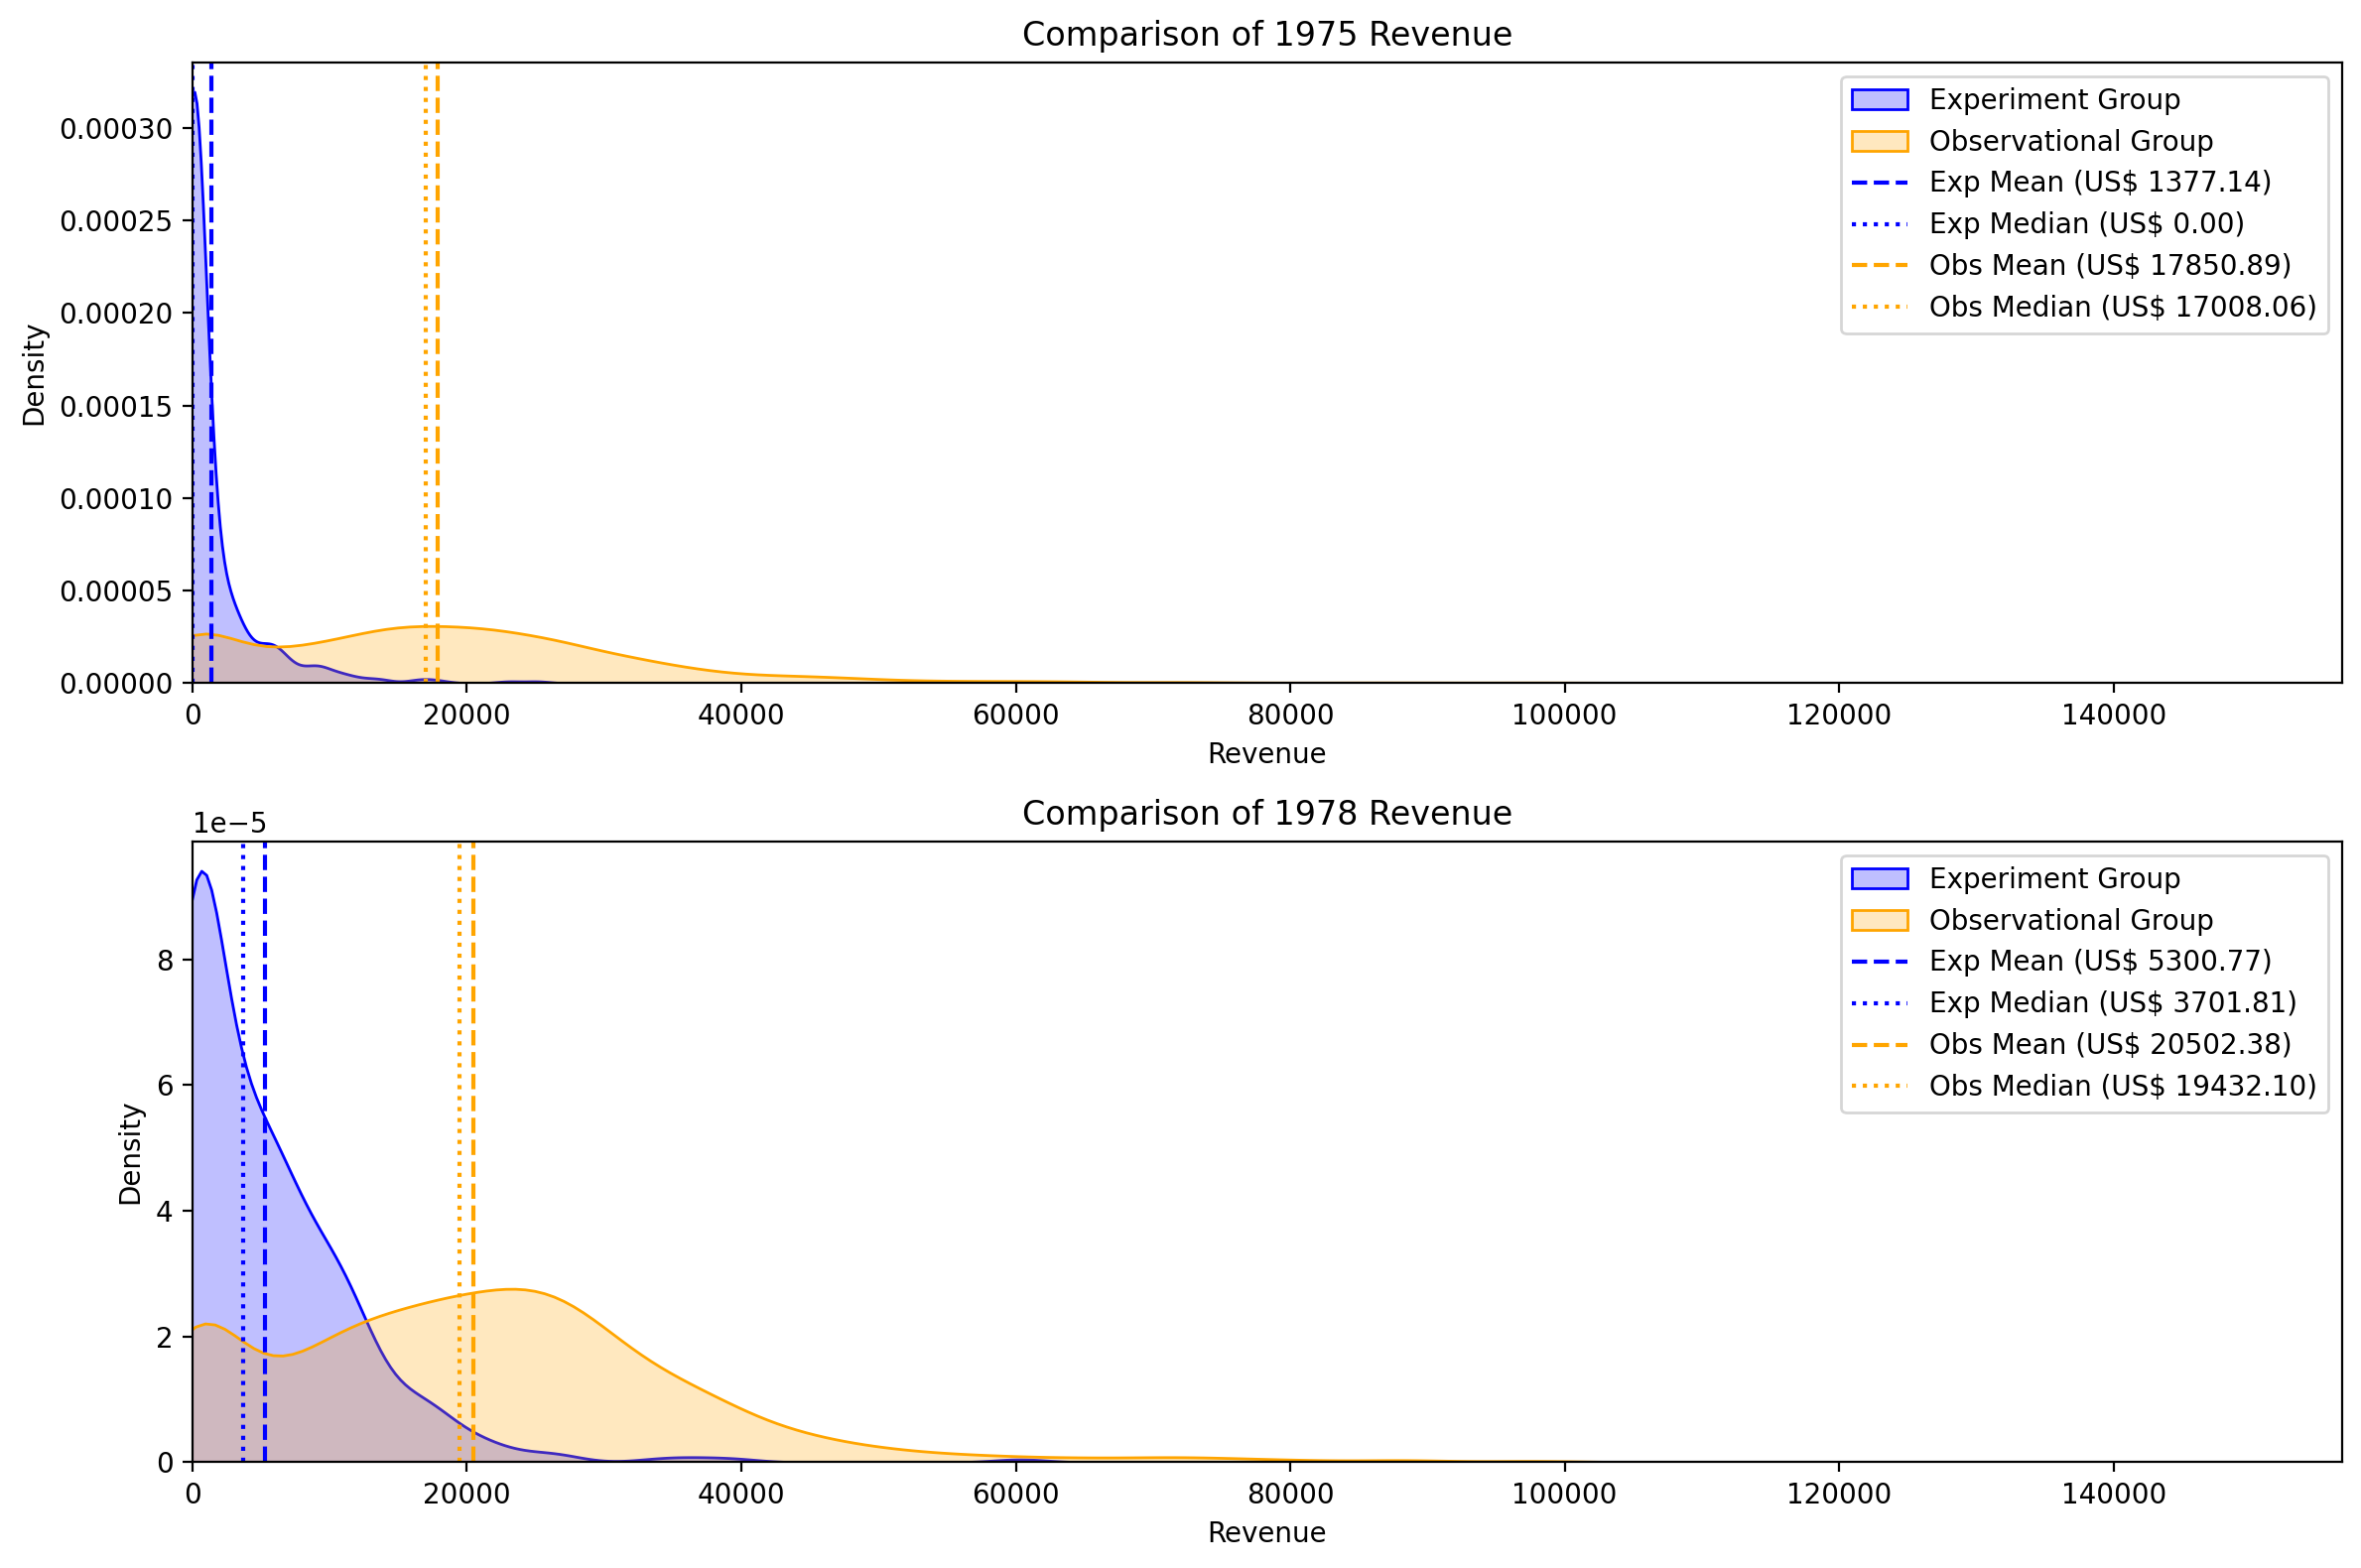

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=200)

columns = ["re75", "re78"]
titles = ["1975 Revenue", "1978 Revenue"]

global_min = min(lalonde_exp[columns].min().min(), lalonde_obs[columns].min().min())
global_max = max(lalonde_exp[columns].max().max(), lalonde_obs[columns].max().max())

for i, column in enumerate(columns):
    sns.kdeplot(
        lalonde_exp[column],
        ax=axes[i],
        color="blue",
        label="Experiment Group",
        fill=True,
    )
    sns.kdeplot(
        lalonde_obs[column],
        ax=axes[i],
        color="orange",
        label="Observational Group",
        fill=True,
    )

    exp_mean = lalonde_exp[column].mean()
    exp_median = lalonde_exp[column].median()
    obs_mean = lalonde_obs[column].mean()
    obs_median = lalonde_obs[column].median()

    axes[i].axvline(
        exp_mean, color="blue", linestyle="--", label=f"Exp Mean (US$ {exp_mean:.2f})"
    )
    axes[i].axvline(
        exp_median,
        color="blue",
        linestyle=":",
        label=f"Exp Median (US$ {exp_median:.2f})",
    )

    axes[i].axvline(
        obs_mean, color="orange", linestyle="--", label=f"Obs Mean (US$ {obs_mean:.2f})"
    )
    axes[i].axvline(
        obs_median,
        color="orange",
        linestyle=":",
        label=f"Obs Median (US$ {obs_median:.2f})",
    )

    axes[i].set_title(f"Comparison of {titles[i]}")
    axes[i].set_xlabel("Revenue")
    axes[i].set_ylabel("Density")
    axes[i].set_xlim(global_min, global_max)
    axes[i].legend()

plt.tight_layout()
plt.show()

* The above graph shows us that those in the observational group are at typically higher 

## Backdoor Estimate

### Experimental Data

In [6]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_lr,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


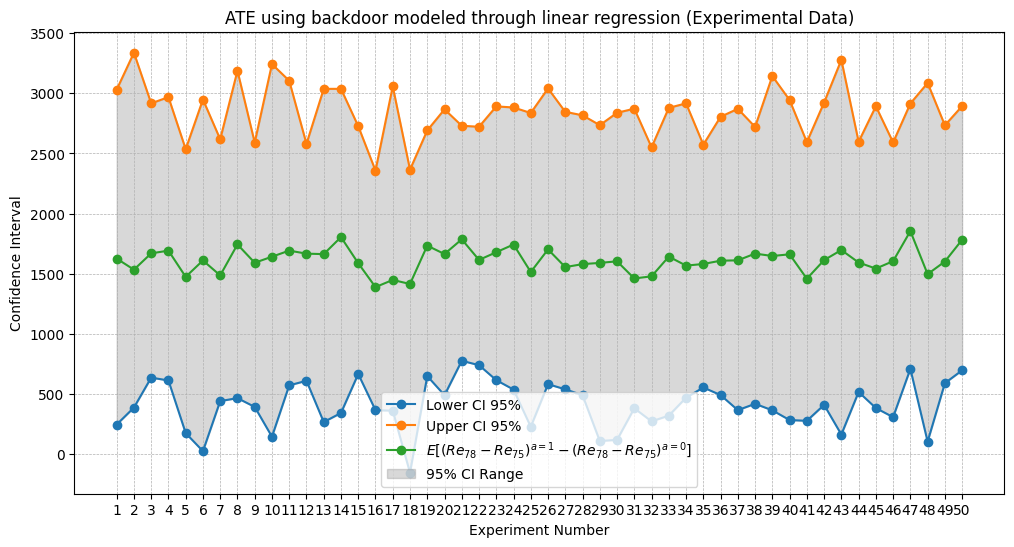

In [7]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["experiment"],
    ci_df["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Experimental Data)")
plt.legend()
plt.show()

In [8]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
23,1742.626911,536.606464,2882.241991,24
45,1604.203962,307.167022,2591.591453,46
21,1614.583822,739.459443,2721.851484,22
33,1567.227480,469.425604,2916.467719,34
36,1611.085812,365.514371,2871.031969,37
25,1701.952789,581.474835,3040.402461,26
13,1804.356548,341.948688,3037.142226,14
31,1478.116091,272.143043,2550.988663,32
2,1669.095351,635.703566,2916.669111,3
28,1589.809659,108.630996,2735.115436,29


### Observational Data

In [9]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_lr,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]


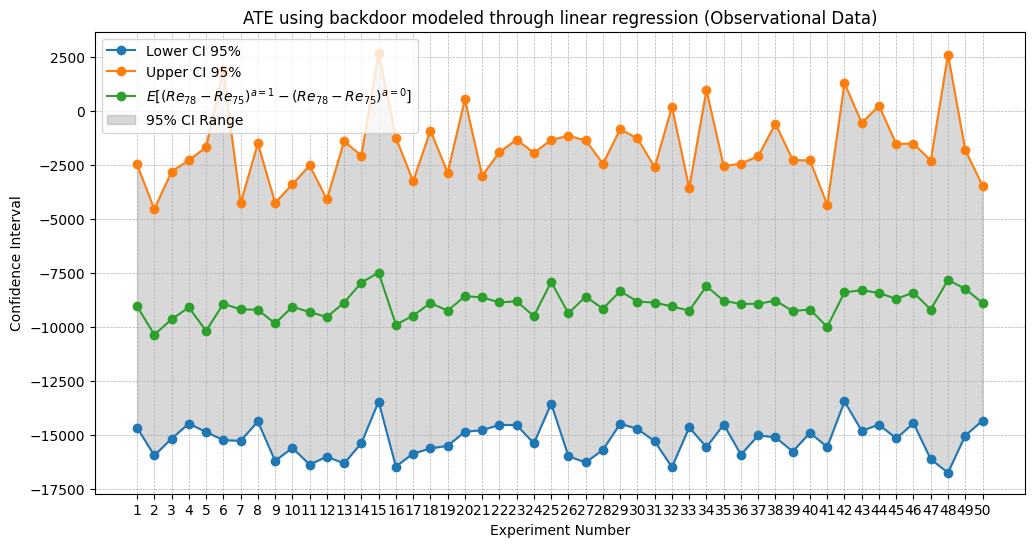

In [10]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["experiment"],
    ci_df["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Observational Data)")
plt.legend()
plt.show()

In [11]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
24,-7917.225553,-13553.627984,-1336.227181,25
39,-9196.305698,-14905.842340,-2288.572432,40
2,-9654.763946,-15177.835332,-2808.288818,3
16,-9483.351149,-15868.154269,-3257.948209,17
38,-9266.644056,-15774.151256,-2274.189757,39
26,-8597.505910,-16281.763663,-1357.077337,27
7,-9211.855075,-14381.966290,-1495.514676,8
47,-7826.893451,-16756.164016,2611.510669,48
8,-9841.661201,-16207.642617,-4253.677133,9
27,-9158.118512,-15695.730922,-2438.936601,28


But this estimate doesn't seem plausible with the observational data.

## Using a's parameter

### Experimental Data

In [12]:
backdoor_result = backdoor_param_a(
    lalonde_exp,
    "treat",
    "re78_re75",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 1682.59.


In [13]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_param_a,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s]


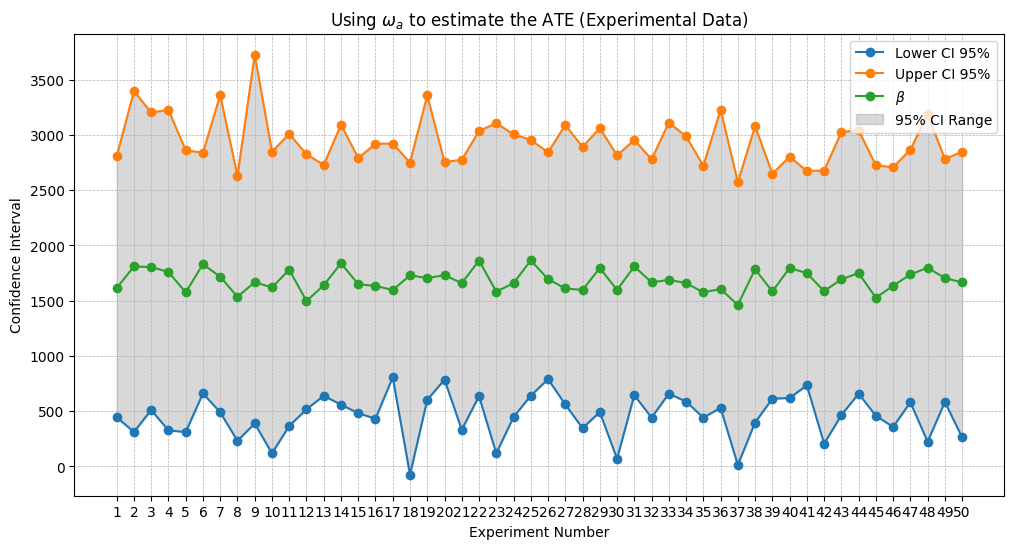

In [14]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Experimental Data)")
plt.legend()
plt.show()

In [15]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
42,1692.602374,463.732335,3026.052653,43
27,1596.734692,345.522525,2892.084859,28
20,1658.158963,331.794355,2775.372472,21
48,1704.464318,583.036617,2781.894602,49
40,1749.121747,733.765667,2673.882012,41
22,1581.575087,117.713321,3106.965538,23
28,1795.088833,491.290850,3060.741142,29
47,1797.642647,223.600903,3186.787468,48
12,1638.813208,639.157080,2728.525683,13
29,1597.044885,69.183668,2815.325772,30


### Using Observational data

In [16]:
backdoor_result = backdoor_param_a(
    lalonde_obs,
    "treat",
    "re78_re75",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 859.77.


In [17]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_param_a,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.91it/s]


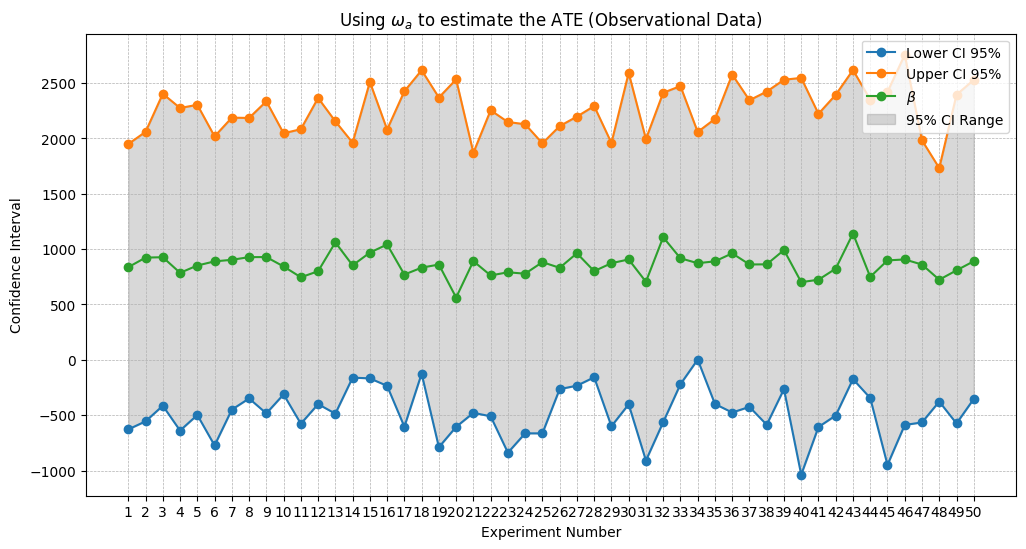

In [18]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Observational Data)")
plt.legend()
plt.show()

In [20]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
16,770.041558,-604.344555,2426.020976,17
13,853.335060,-160.808060,1961.224871,14
46,860.416590,-565.517327,1982.689801,47
9,843.392935,-312.585506,2046.494253,10
36,861.257421,-425.024228,2345.196088,37
32,917.378090,-220.539097,2473.048581,33
1,923.367497,-555.772960,2059.455147,2
21,762.103975,-510.010784,2254.336449,22
34,889.644050,-399.104069,2176.411280,35
26,962.575432,-233.623868,2197.256195,27


* We might be overfitting with the backdoor estimator
* The outcome is linearly dependent on A